In [31]:
# default_exp data.finance.forecast

In [32]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
from libs import is_lib_exists

In [35]:
required_libs = [ ("numpy", "numpy"),
                  ("pandas", "pandas"),
                  ("seaborn", "seaborn"),
                  ("matplotlib", "matplotlib"),
                  ("investpy", "investpy"),
                  ("dateutil", "python-dateutil"),
                  ("fbprophet", "fbprophet"),
                ]

In [36]:
for (clz,lib) in required_libs:
    if not is_lib_exists(clz):
        print(f"Installing {lib}")
        !pip install -qq {lib}
    else:
        print(f"{lib} exists")

numpy exists
pandas exists
seaborn exists
matplotlib exists
investpy exists
python-dateutil exists
fbprophet exists


In [95]:
#export
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import investpy
from pathlib import Path
from dateutil.relativedelta import *
from datetime import *
import calendar
import traceback
from ts_utils import *

In [96]:
%matplotlib inline

In [51]:
#%quickref
#%magic
#%env

In [40]:
from IPython.display import display, Image

# Finance Data

> Functionality to gather finance data.

The classes here provide bases classes used to gather finance data for model training.

In [42]:
#hide
from nbdev.showdoc import *

In [43]:
# Dataset path
DATASET_PATH = Path("../../data")  

# Country to analyze
COUNTRY = "malaysia"

# Dataset
DATASET = DATASET_PATH/f"ftse_klse_investing.csv"

# Stocks summary
DATASET_STOCKS_SUMMARY = DATASET_PATH/f"stocks_summary.csv"

## FTSE KLSE

In [44]:
# Retrieve stock components
dataset = investpy.get_stocks(country=COUNTRY)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 929 entries, 0 to 928
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   country    929 non-null    object
 1   name       929 non-null    object
 2   full_name  929 non-null    object
 3   isin       929 non-null    object
 4   currency   929 non-null    object
 5   symbol     929 non-null    object
dtypes: object(6)
memory usage: 43.7+ KB


In [45]:
# Save the dataset
dataset.to_csv(DATASET, index=False)

# dataset = pd.read_csv(DATASET, header=0, sep=',', quotechar='"')

In [52]:
print(f"Number of stock - {len(dataset)}")
display(dataset.head(3))

Number of stock - 929


,country,name,full_name,isin,currency,symbol
0,malaysia,Media Chinese Int,Media Chinese International Ltd,BMG5959D1048,MYR,MDCH
1,malaysia,AMMB,AMMB Holdings Bhd,MYL1015OO006,MYR,AMMB
2,malaysia,CIMB Group,CIMB Group Holdings Bhd,MYL1023OO000,MYR,CIMB


In [232]:
FROM_DATE = '1/3/2020'

#TO_DATE = datetime.strftime(date.today(), '%d/%m/%Y')
TO_DATE="30/9/2020"

TEST_DATE = "2020-09-01"

TEST_STOCK_CODE="MBBM"

print(FROM_DATE, TO_DATE)

1/3/2020 30/9/2020


In [201]:
df = investpy.get_stock_historical_data(stock=TEST_STOCK_CODE,
                                        country=COUNTRY,
                                        from_date=FROM_DATE,
                                        to_date=TO_DATE)
df.reset_index(inplace=True)
df.tail()

,Date,Open,High,Low,Close,Volume,Currency
139,2020-09-24,7.20,7.21,7.09,7.09,9661400,MYR
140,2020-09-25,7.12,7.15,7.08,7.08,4508000,MYR
141,2020-09-28,7.10,7.14,7.08,7.10,6190600,MYR
142,2020-09-29,7.12,7.25,7.11,7.16,6187200,MYR
143,2020-09-30,7.19,7.23,7.15,7.22,4470000,MYR


In [202]:
ts = df[['Date','Close']].copy()
ts.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)
ts.set_index(['ds'], inplace=True)
ts = ts['y']
ts.name = TEST_STOCK_CODE
ts

ds
2020-03-02    8.39
2020-03-03    8.41
2020-03-04    8.47
2020-03-05    8.53
2020-03-06    8.50
              ... 
2020-09-24    7.09
2020-09-25    7.08
2020-09-28    7.10
2020-09-29    7.16
2020-09-30    7.22
Name: MBBM, Length: 144, dtype: float64

In [203]:
print("population --> len:", len(ts), "| mean:", round(ts.mean()), " | std:", round(ts.std()))
w = 30
print("moving --> len:", w, " | mean:", round(ts.ewm(span=w).mean()[-1]), " | std:", round(ts.ewm(span=w).std()[-1]))

population --> len: 144 | mean: 8  | std: 0
moving --> len: 30  | mean: 7  | std: 0


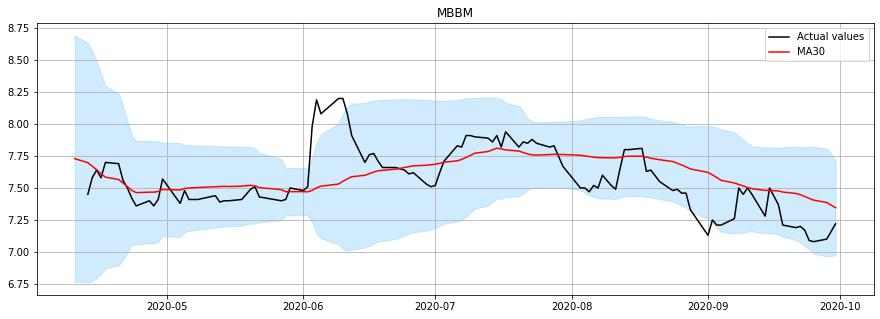

In [204]:
plot_ts(ts, plot_ma=True, plot_intervals=True, window=w, figsize=(15,5))

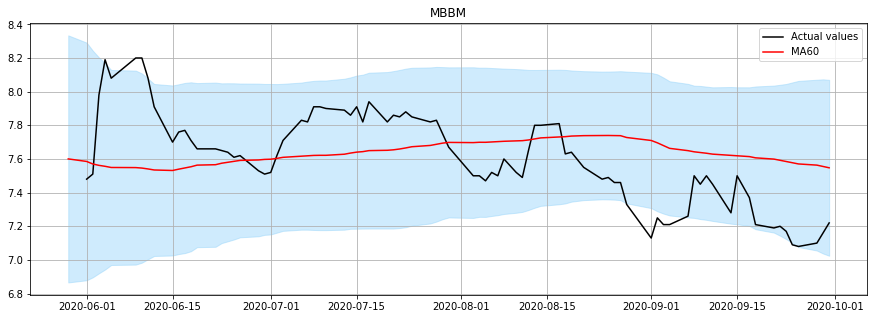

In [205]:
# looks like a soft downtrend, it should be clear with a window of 1 year
plot_ts(ts, plot_ma=True, plot_intervals=True, window=60, figsize=(15,5))

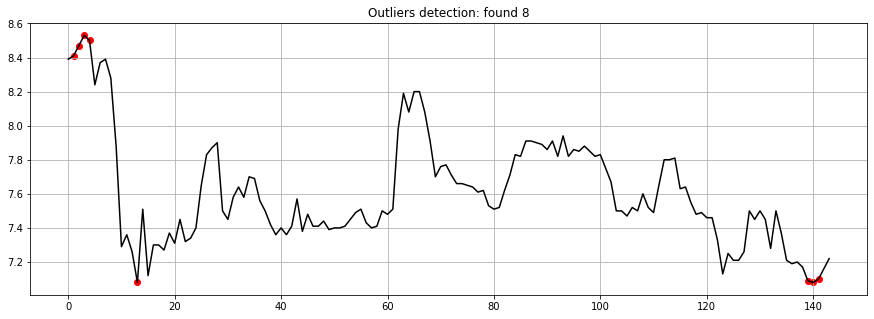

In [206]:
# outliers
dtf_outliers = find_outliers(ts, perc=0.05, figsize=(15,5))

In [207]:
# Remove outliers?
# ts_clean = remove_outliers(ts, outliers_idx=dtf_outliers[dtf_outliers["outlier"]==1].index, figsize=(15,5))

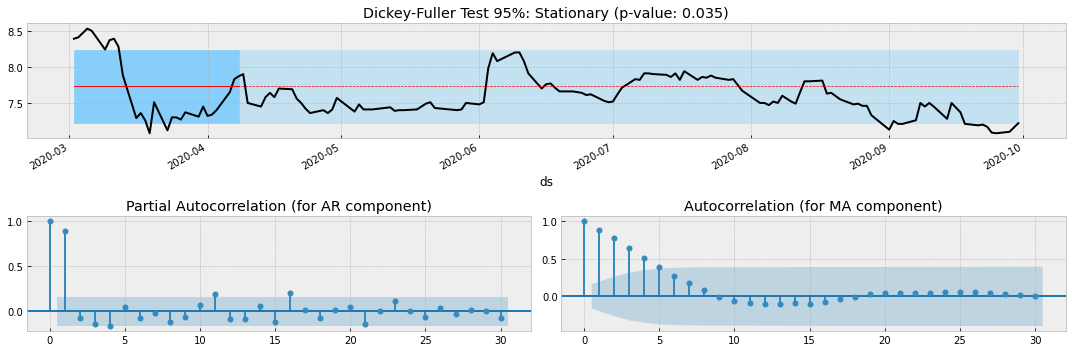

In [208]:
test_stationarity_acf_pacf(ts, sample=0.20, maxlag=w, figsize=(15,5))

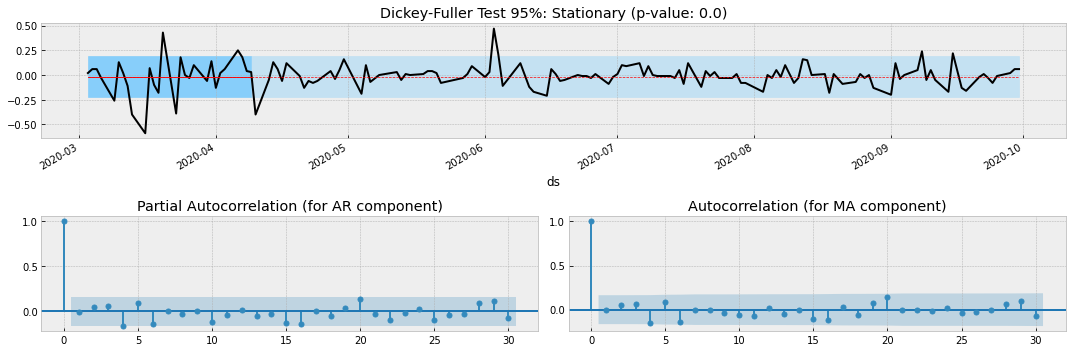

In [209]:
# try with differentiating ts
test_stationarity_acf_pacf(diff_ts(ts, order=1), sample=0.20, maxlag=30, figsize=(15,5))

/Users/mengwangk/workspace/development/investor/investor/experiment/science/nbdev/nbs/ts_utils.py:138: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition = smt.seasonal_decompose(ts, freq=s)


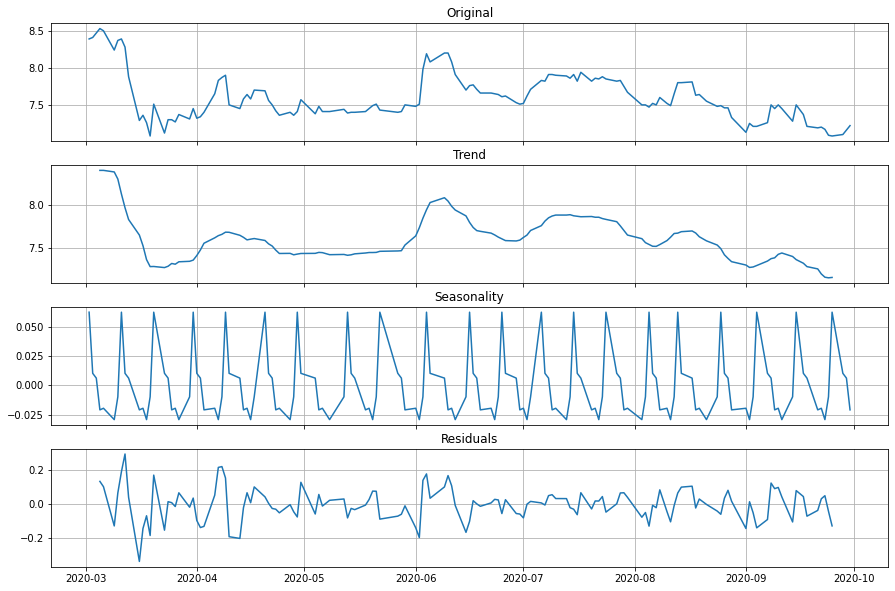

In [210]:
# seasonality
dic_decomposed = decompose_ts(ts, s=7, figsize=(15,10))

--- splitting at index:  123 | 2020-09-01 00:00:00 | test size: 0.15  ---


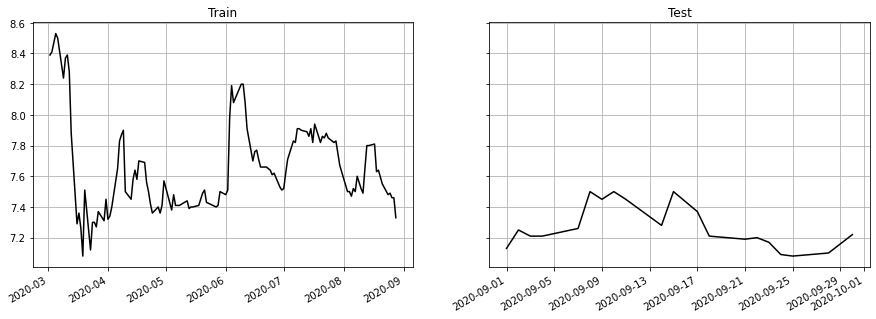

(123, 21)

In [235]:
# Pre-processing
ts_train, ts_test = split_train_test(ts, exog=None, test=TEST_DATE, plot=True, figsize=(15,5))
len(ts_train), len(ts_test)

In [236]:
dtf_train = ts_train.reset_index().rename(columns={TEST_STOCK_CODE:'y'})
dtf_test = ts_test.reset_index().rename(columns={TEST_STOCK_CODE:'y'})

dtf_train.tail()

,ds,y
118,2020-08-24,7.48
119,2020-08-25,7.49
120,2020-08-26,7.46
121,2020-08-27,7.46
122,2020-08-28,7.33


In [237]:
dtf_holidays = None

In [240]:
model = Prophet()
#model = Prophet(daily_seasonality=True, yearly_seasonality=False)
#model = Prophet(growth="linear", changepoints=None, n_changepoints=25, seasonality_mode="multiplicative",
#                yearly_seasonality="auto", weekly_seasonality="auto", daily_seasonality=False,
#                holidays=dtf_holidays, interval_width=0.80)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
144 2020-09-19  7.393944    7.056352    7.616643     7.312588     7.474203   
145 2020-09-20  7.387992    7.123766    7.674456     7.301674     7.474841   
146 2020-09-21  7.382039    7.035324    7.608783     7.289982     7.473074   
147 2020-09-22  7.376087    7.112358    7.678851     7.280281     7.472514   
148 2020-09-23  7.370135    7.107004    7.687762     7.267150     7.472378   
149 2020-09-24  7.364182    7.113711    7.695702     7.253631     7.471757   
150 2020-09-25  7.358230    7.073837    7.660586     7.244293     7.472639   
151 2020-09-26  7.352277    7.005691    7.589953     7.230867     7.473292   
152 2020-09-27  7.346325    7.081118    7.681588     7.218890     7.474185   
153 2020-09-28  7.340372    7.014246    7.608484     7.204967     7.476278   

     additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
144       -0.055803             -0.055803             -0.055803 

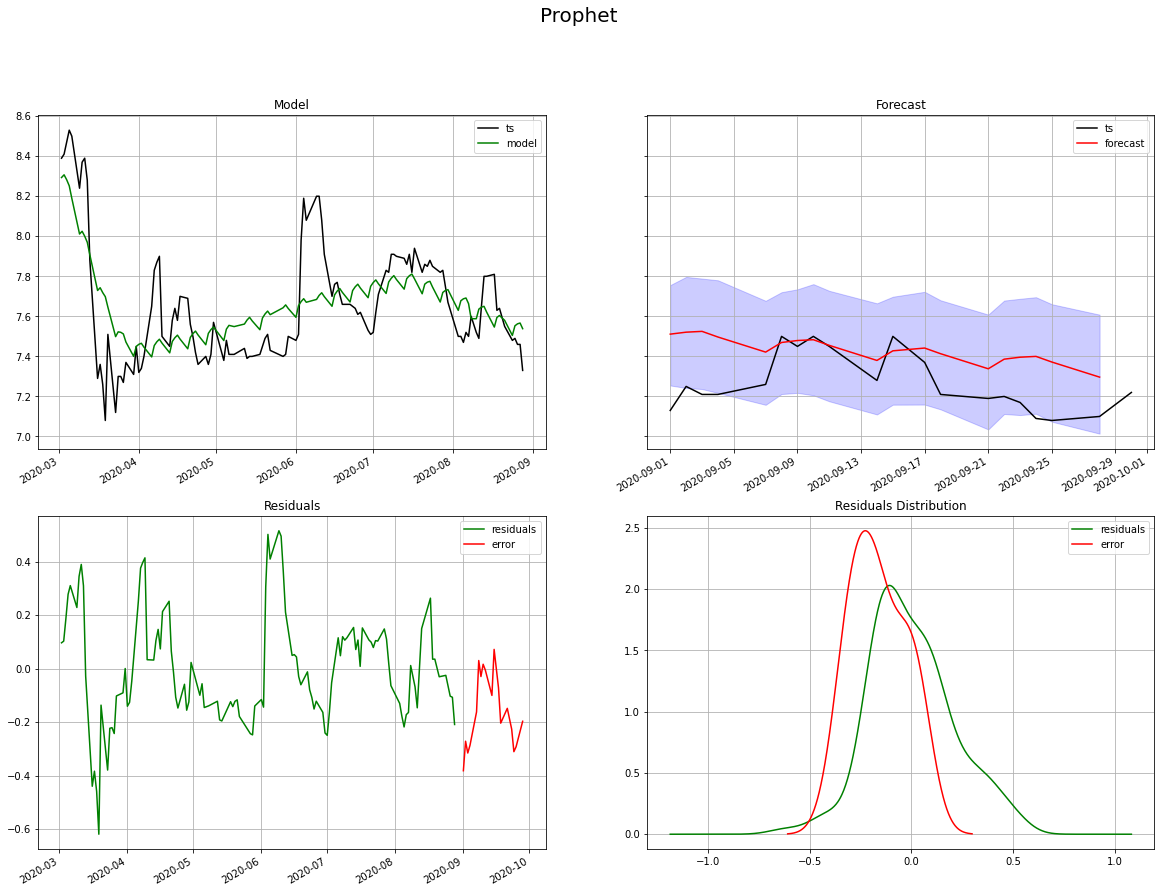

Training --> Residuals mean: 0.0  | std: 0.0
Test --> Error mean: -0.0  | std: 0.0  | mae: 0.0  | mape: 2.0 %  | mse: 0.0  | rmse: 0.0


In [241]:
dtf, model = fit_prophet(dtf_train, dtf_test, model=model, freq="D", figsize=(20,15))

In [222]:
# forecast
dtf = ts.reset_index().rename(columns={"date":"ds", TEST_STOCK_CODE:"y"})
dtf.tail()

,ds,y
139,2020-09-24,7.09
140,2020-09-25,7.08
141,2020-09-28,7.10
142,2020-09-29,7.16
143,2020-09-30,7.22


In [217]:
model = Prophet(daily_seasonality=True)

In [219]:
#future = forecast_prophet(dtf, model, end=TEST_DATE, freq="D", zoom=20, figsize=(15,5))